In [2]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

## Scenario 2
Gains moyen faibles avec 10 bras

### Paramètres du scenario

In [6]:
#Params du scenario 2
p = np.array([0.05, 0.02, 0.01, 0.05, 0.02, 0.01, 0.05, 0.02, 0.01, 0.1]) #Param des Bernoulli
K= p.shape[0] #Nb de bras
p_star = np.max(p)
Delta= ( np.ones(K)*p_star ) - p

T= 50000 #Nb max d'iterations

print("Pi:",p)
print("Deltai:",Delta)

Pi: [0.05 0.02 0.01 0.05 0.02 0.01 0.05 0.02 0.01 0.1 ]
Deltai: [0.05 0.08 0.09 0.05 0.08 0.09 0.05 0.08 0.09 0.  ]


## Partie UCB

In [7]:
alpha=3
N3 = np.zeros(K) #Nb de fois ou le bras K a été tiré

Reward_UCB3 = np.zeros((K,T),dtype=np.int) #Recompense avec chaque bras
Action_UCB3 = np.zeros((K,T),dtype=np.int) #Bras choisi a chaque étape

UCB3 = np.zeros(K) #Gain UCB pour chaque bras

In [8]:
#On commence en explorant les K bras au moins une fois
for t in range(K):
    N3[t]=1
    Reward_UCB3[t,t]= np.random.binomial(1, p[t])
    Action_UCB3[t,t]=1

for t in range(K,T):
    #Added slight optimization (sum only up to t)
    for i in range(K):
        UCB3[i] = np.sum(Reward_UCB3[i,:t])/N3[i]+np.sqrt( (alpha*math.log(t))/(2*N3[i]) )
            
    select = np.argmax(UCB3)
    #print("t & select",t, select)
    N3[select]=N3[select]+1
    Action_UCB3[select,t]=1
    Reward_UCB3[select,t]= np.random.binomial(1,p[select])

cumReward=np.cumsum(Reward_UCB3,axis=1) #Reward accumulé pour chaque bras en fonction du temps
totalReward=np.sum(cumReward,axis=0) #Reward sur tout les bras accumulé en fonction du temps

t & Reward (total) : 49999 3865


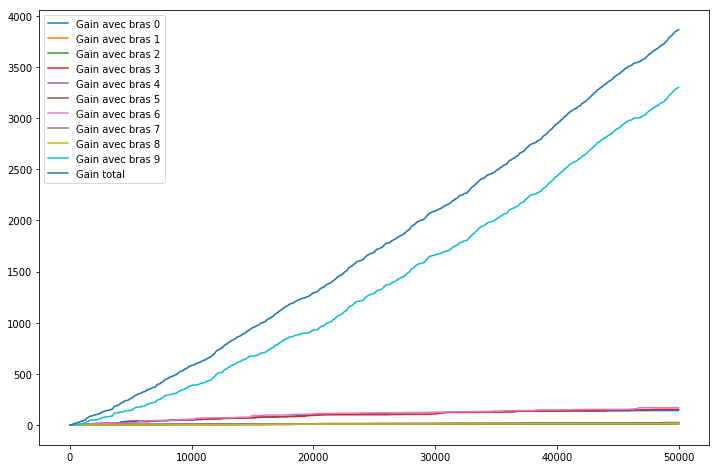

In [9]:
print("t & Reward (total) :",t, totalReward[t-1] )
   
fig=plt.figure(figsize=(12,8))
##fig=plt.figure()  
ax1 = fig.add_subplot(1,1,1)
for i in range (K):
##ax1.plot(c_error,marker='.',linestyle='-',label='Online avec gradient à pas constant')
    ax1.plot(cumReward[i,:],linestyle='-',label='Gain avec bras '+str(i))
#ax1.plot(totalReward[1,:],linestyle='-',label='Gain avec bras 2')
ax1.plot(totalReward[:],linestyle='-',label='Gain total')
ax1.legend(loc='best')
plt.show()

t & Pseudo-Regret : 49999 1138.16


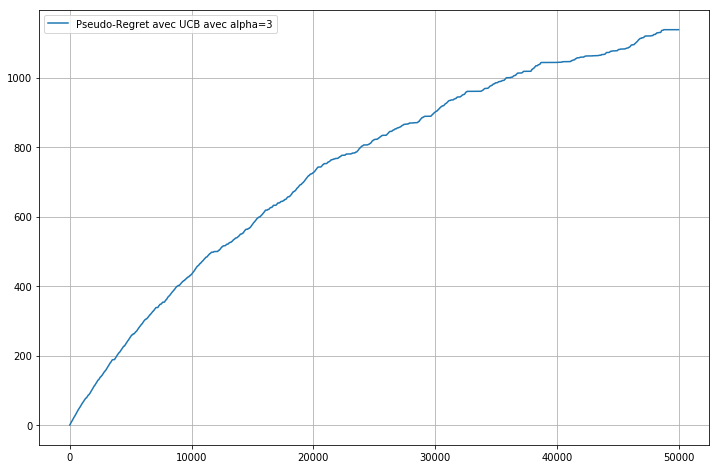

In [10]:
totalAction=np.cumsum(Action_UCB3,axis=1) #Nb d'actions accumulé sur chaque bras
cumRegret=np.dot(Delta,totalAction[:,:]) #Regret accumulé

print("t & Pseudo-Regret :",t,cumRegret[T-1])

fig=plt.figure(figsize=(12,8))
##fig=plt.figure()  
ax1 = fig.add_subplot(1,1,1)
ax1.plot(cumRegret[:],linestyle='-',label='Pseudo-Regret avec UCB avec alpha=3')
ax1.legend(loc='best')
ax1.grid()
#ax1.xscale('log')
plt.show()

## UCB (old)

In [4]:
sub_arm_list_ucb = []
start_time = time.time()

for run in range(runs):
    if(run == 0 or run % 1000 == 0):
        print("run =", run)
    
    #ucb Params Iinitialization
    N = np.zeros(K) #Nb de fois ou le bras 1 ou 2 a été tiré
    rewards_ucb = np.zeros((K, T), dtype=np.int) #Recompense avec chaque bras
    action_ucb = np.zeros((K, T), dtype=np.int) #Bras choisi a chaque étape
    ucb = np.zeros(K) #ucb pour chaque bras

    #On commence en explorant les 2 bras au moins une fois
    #t between 0 & K
    for t in range(K):
        N[t]=1
        rewards_ucb[t,t]= np.random.binomial(1, p[t])
        action_ucb[t,t]=1

    #t >= K
    for t in range(K, T):
        for k in range(K):
            ucb[k] = sum(rewards_ucb[k,:t])/N[k]+np.sqrt((alpha*math.log(t))/(2*N[k]))

        select = np.argmax(ucb)
        N[select] += 1
        action_ucb[select,t] = 1
        rewards_ucb[select,t] = np.random.binomial(1,p[select])

    sub_arm = np.copy(action_ucb[0,])
    #print(sub_arm)
    sub_arm_list_ucb.append(sub_arm)

print("Time for UCB, with T =", T, ", runs =", runs, ":", (time.time() - start_time), "seconds")
#NB: would take 300hrs for
#T= 2*10**4
#runs = 50*10**3 

run = 0
Time for UCB, with T = 20000 , runs = 10 : 278.3840022087097 seconds


In [5]:
mean_sub_arm = np.mean(sub_arm_list_ucb, axis=0 ) #Mean number of the suboptimal arm as a function of time
sub_arm_draws_T = np.zeros(runs) #number of draws of the suboptimal arm at tim n=5000
for i in range(runs):
    sub_arm_draws_T[i] = np.sum(sub_arm_list_ucb[i][:5000])

## KL-UCB

In [16]:
klucb = kl_ucb_policy.KLUCBPolicy(K, Delta)

klucb.reset()
actions_klucb = np.zeros((K, T), dtype=np.int)
rewards_klucb = np.zeros((K, T), dtype=np.int)

for t in range(T):
    arm_klucb = klucb.select_next_arm()
    print("arm :", arm_klucb)
    actions_klucb[arm_klucb,t] = 1
    rewards_klucb[arm_klucb,t] = np.random.binomial(1, p[arm_klucb])
    klucb.update_state(arm_klucb, rewards_klucb[arm_klucb,t])

arm : 0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
%%capture
# KL-UCB avec 2 bras
klucb = kl_ucb_policy.KLUCBPolicy(K, Delta)

sub_arm_list_klucb = []
start_time = time.time()

for run in range(runs):
    if(run == 0 or run % 1000 == 0):
        print("run =", run)
        
    klucb.reset()
    actions_klucb = np.zeros((K, T), dtype=np.int)
    rewards_klucb = np.zeros((K, T), dtype=np.int)

    for t in range(T):
        arm_klucb = klucb.selectNextArm()
        #print("arm :", arm)
        actions_klucb[arm_klucb,t] = 1
        rewards_klucb[arm_klucb,t] = np.random.binomial(1, p[arm_klucb])
        klucb.updateState(arm_klucb, rewards_klucb[arm_klucb,t])
        
    sub_arm = np.copy(actions_klucb[0,])
    #print(sub_arm)
    sub_arm_list_klucb.append(sub_arm)

time_spent = time.time() - start_time

NameError: name 'runs' is not defined

In [65]:
print("Time for KL-UCB, with T =", T, ", runs =", runs, ":", (time_spent), "seconds")
#NB: would take 300hrs for
#T= 2*10**4
#runs = 50*10**3 

Time for UCB, with T = 5000 , runs = 100 : 80.50862550735474


In [56]:
mean_sub_arm_klucb = np.mean(sub_arm_list_klucb, axis=0 ) #Mean number of the suboptimal arm as a function of time
sub_arm_draws_T_klucb = np.zeros(runs) #number of draws of the suboptimal arm at tim n=5000
for i in range(runs):
    sub_arm_draws_T_klucb[i] = np.sum(sub_arm_list_klucb[i][:5000])

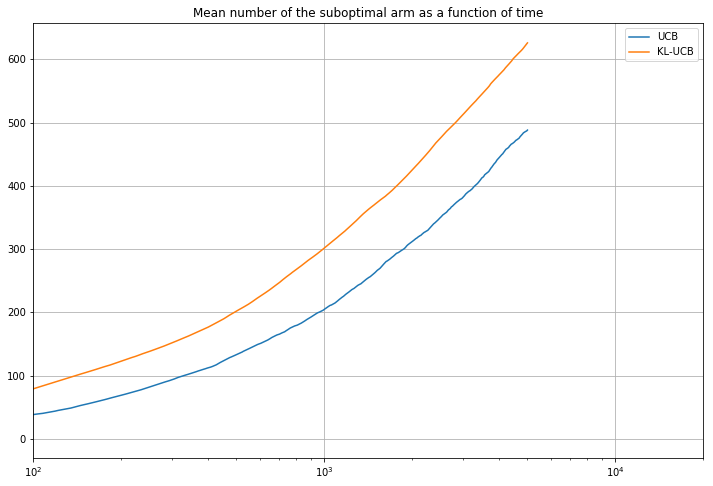

In [57]:
#Plot Article's figure 1 (left) KL-UCB
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(np.cumsum(mean_sub_arm), linestyle='-', label='UCB')
ax.semilogx(np.cumsum(mean_sub_arm_klucb), linestyle='-', label='KL-UCB')
ax.grid(True)
ax.legend(loc='best')
ax.set_title('Mean number of the suboptimal arm as a function of time')
plt.xlim( 10**2, 2*10**4 ) 
plt.show()

No handles with labels found to put in legend.


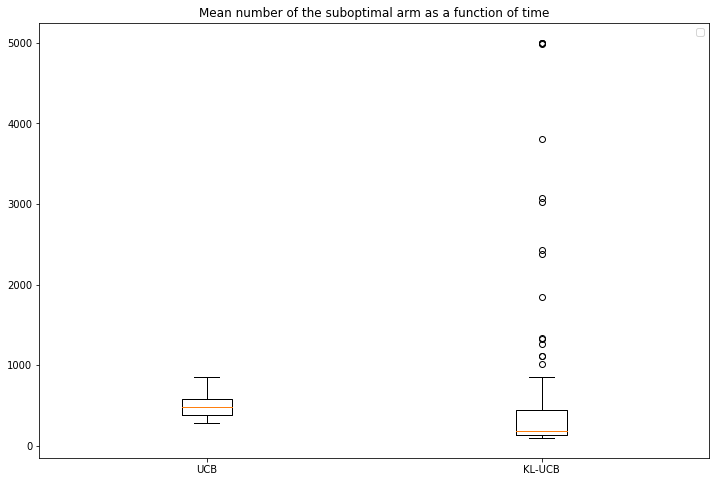

In [58]:
#Plot Article's figure 1 (right)
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.boxplot([sub_arm_draws_T, sub_arm_draws_T_klucb])
ax.set_xticklabels(['UCB', 'KL-UCB'])
ax.legend(loc='best')
ax.set_title('Mean number of the suboptimal arm as a function of time')
plt.show()

In [81]:
#Write data in files
#ucb
parameters_ucb = {
    'sub_arm_list': sub_arm_list_ucb
}
output_ucb = open('data/ucb_scenario_1.pkl', 'wb')
pickle.dump(parameters_ucb, output_ucb)
output_ucb.close()

#kl-ucb
parameters_klucb = {
    'sub_arm_list': sub_arm_list_klucb
}
output_klucb = open('data/kl_ucb_scenario_1.pkl', 'wb')
pickle.dump(parameters_klucb, output_klucb)
output_klucb.close()

In [82]:
#If already something in data file
#ucb
file_ucb = 'data/ucb_scenario_1.pkl'
#read
read_ucb = open(file_ucb, 'rb')
parameters_ucb = pickle.load(read_ucb)
read_ucb.close()
#update
parameters_ucb['sub_arm_list'] += sub_arm_list_ucb
#write
write_ucb = open(file_ucb, 'wb')
pickle.dump(parameters_ucb, write_ucb)
write_ucb.close()